# Trabajo Práctico 1 : Reservas de Hotel


## Librerias


Importamos las librerias que vamos a necesitar en el transcurso del trabajo.


In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sc
import scipy.stats as st
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, precision_recall_curve, roc_curve
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score, accuracy_score , roc_auc_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, classification_report
random.seed(33)

pd.set_option('display.max_columns', 200)

In [161]:
def mostrar_scores(y_test, y_prediccion):
    accuracy = accuracy_score(y_test,y_prediccion)
    recall = recall_score(y_test,y_prediccion)
    f1 = f1_score(y_test,y_prediccion,)
    precision = precision_score(y_test,y_prediccion)

    print("Accuracy: "+str(accuracy))
    print("Recall: "+str(recall))
    print("Precision: "+str(precision))
    print("f1 score: "+str(f1))

## Ensambles


A continuacion vamos a probar los distintos ensambles pedidos en el trabajo y ver como se comportan con nuestro dataset. Por cada ensamble se submitteara como minimo un csv a kaggle para ver que tan bien generaliza nuestro modelo.
Tambien vamos a utilizar escalados en la mayoria de los casos para luego poder ensamblarlo con svm.

In [162]:
df_ensambles = pd.read_csv('dataframe_chp1.csv')

### KNN


Como es un modelo simple que no va a dar grandes resultados como los demas, crearemos un modelo con los mejores hiperparametros encontrados en la busqueda de los mismos. Tambien, comenzaremos con todas las features del dataset para ver como rinde y, luego, iremos sacando features para ver si podemos mejorar el modelo.


In [163]:
df_a_utilizar = df_ensambles.copy()

In [164]:
columns = [
    'hotel',
    'lead_time',
    'year',
    'week_number',
    'meal_type',
    'country',
    'market_segment',
    'is_repeated_guest',
    'previous_cancellations',
    'booking_changes',
    'deposit_type',
    'agent_id',
    'days_in_waiting_list',
    'customer_type',
    'average_daily_rate',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'is_canceled',
    'total_people'
]

dummy_columns = [
    'hotel',
    'deposit_type',
    'market_segment',
    'agent_id',
    'country',
    'customer_type',
    'meal_type',
]



In [165]:
agentes = df_a_utilizar[['agent_id']].value_counts().reset_index()

agentes.columns = ['agent_id', 'cantidad']
agentes_mayoritarios = agentes[agentes['cantidad'] > 20]
agentes_minoritarios = agentes[agentes['cantidad'] <= 20]

df_agentes_mayoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_mayoritarios['agent_id'])]
df_agentes_minoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id'])]
df_agentes_minoritarios.loc[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id']), 'agent_id'] = 'Otros'

df_agentes = pd.concat([df_agentes_mayoritarios, df_agentes_minoritarios])

paises = df_agentes[['country']].value_counts().reset_index()
paises.columns = ['country', 'cantidad']
paises_mayoritarios = paises[paises['cantidad'] > 15]
paises_minoritarios = paises[paises['cantidad'] <= 15]

df_paises_mayoritarios = df_agentes[df_agentes['country'].isin(paises_mayoritarios['country'])]
df_paises_minoritarios = df_agentes[df_agentes['country'].isin(paises_minoritarios['country'])]
df_paises_minoritarios.loc[df_agentes['country'].isin(paises_minoritarios['country']), 'country'] = 'Otros'

df_encode = pd.concat([df_paises_mayoritarios, df_paises_minoritarios])

filtrado = df_encode[columns]

df_con_dummies = pd.get_dummies(filtrado, columns=dummy_columns, drop_first=True)


df_con_dummies['cuarto_correcto'] = df_ensambles['reserved_room_type'] == df_ensambles['assigned_room_type']
df_con_dummies['cuarto_correcto'] = df_con_dummies['cuarto_correcto'].apply(lambda x: 1 if x == True else 0)

df_trabajo_x = df_con_dummies.drop(['is_canceled'], axis='columns', inplace=False)
df_trabajo_y = df_con_dummies['is_canceled'].copy()

In [166]:
x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=11457,
                                                    stratify=df_con_dummies["is_canceled"].values
                                                    )

Primero observamos los distintos parametros que puede llevar nuestro modelo.


In [167]:
from sklearn.neighbors import KNeighborsClassifier
clasificador_KNN = KNeighborsClassifier()
clasificador_KNN.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

Con esto vamos a darnos una idea de qué cantidad de folds debe utilizar nuestro clasificador. Como nuestro dataset es muy amplio vamos a probar con distintos valores de n, desde 3 a 14, para ver cual es el que mejor se ajusta a nuestro modelo.


In [168]:
cantidad_de_folds = range(3, 15)
metricas = []

for n in cantidad_de_folds:
    clasificador_KNN = KNeighborsClassifier()
    scores = cross_val_score(clasificador_KNN, x_train.values, y_train, cv=n, scoring='f1')
    metricas.append(scores.mean())
    print("cantidad de folds = "+str(n) +" -> media f1-score:"+str(scores.mean()))

cantidad de folds = 3 -> media f1-score:0.7109825333985503
cantidad de folds = 4 -> media f1-score:0.7132199580886689
cantidad de folds = 5 -> media f1-score:0.7189762398407014
cantidad de folds = 6 -> media f1-score:0.7206098563015958
cantidad de folds = 7 -> media f1-score:0.7218534926116409
cantidad de folds = 8 -> media f1-score:0.7210350486039983
cantidad de folds = 9 -> media f1-score:0.7225415684637837
cantidad de folds = 10 -> media f1-score:0.7234452550049374
cantidad de folds = 11 -> media f1-score:0.7240770581088963
cantidad de folds = 12 -> media f1-score:0.7239425788186055
cantidad de folds = 13 -> media f1-score:0.7242209518006385
cantidad de folds = 14 -> media f1-score:0.7256763200025749


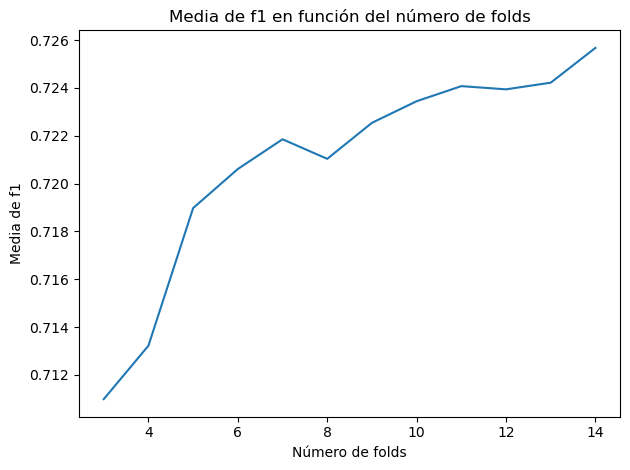

In [169]:
sns.lineplot(x=cantidad_de_folds, y=metricas)
plt.xlabel("Número de folds")
plt.ylabel("Media de f1")
plt.title("Media de f1 en función del número de folds")
plt.tight_layout()
plt.show()

In [170]:
mejor_score_folds = max(metricas)
indice_mejor_cantidad_folds = metricas.index(mejor_score_folds)
print(f"La media maxima es con {indice_mejor_cantidad_folds + 3} folds y su score es de {mejor_score_folds}")

La media maxima es con 14 folds y su score es de 0.7256763200025749


Podemos utilizar esta información para ajustar mejor nuestra búsqueda de hiperparámetros. Si bien 14 folds es el que mejor se ajusta, vamos a probar la búsqueda de hiperparámetros con 7 folds nada mas, ya que, con una cantidad elevada de folds nuestro algoritmo de búsqueda es muy lento.


In [171]:
grilla_parametros = {'n_neighbors': range(3, 15),
                     'weights': ['distance', 'uniform'],
                     'algorithm': ['ball_tree', 'kd_tree'],
                     'metric': ['euclidean', 'manhattan', 'chebyshev']
                     }

iteraciones = 50

knn_hiperparams = RandomizedSearchCV(estimator=KNeighborsClassifier(),
                                        param_distributions=grilla_parametros,
                                        scoring=make_scorer(f1_score),
                                        cv=StratifiedKFold(n_splits=7),
                                        n_iter=iteraciones, n_jobs=-1, random_state=33)
                                        

knn_hiperparams.fit(x_train.values, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=7, random_state=None, shuffle=False),
                   estimator=KNeighborsClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree'],
                                        'metric': ['euclidean', 'manhattan',
                                                   'chebyshev'],
                                        'n_neighbors': range(3, 15),
                                        'weights': ['distance', 'uniform']},
                   random_state=33, scoring=make_scorer(f1_score))

In [172]:
print(knn_hiperparams.cv_results_['mean_test_score'])
print(knn_hiperparams.best_params_)
print(knn_hiperparams.best_score_)

[0.70529706 0.70545427 0.73570698 0.73373048 0.7482327  0.69061434
 0.77186705 0.74003556 0.78327218 0.75714044 0.73316749 0.73468378
 0.7469195  0.74683815 0.7739494  0.73246713 0.73279507 0.71625707
 0.69884431 0.74698642 0.73716866 0.68838419 0.67293193 0.73327429
 0.73663302 0.78371648 0.73410985 0.77955293 0.67238417 0.6951684
 0.72999979 0.782271   0.68396182 0.69046036 0.78071314 0.73227063
 0.74796509 0.68654906 0.74832206 0.74935939 0.730519   0.69507978
 0.67407334 0.7393332  0.69891133 0.73413581 0.75656881 0.72141697
 0.75010061 0.7398416 ]
{'weights': 'distance', 'n_neighbors': 12, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
0.783716476398599


Con esto podemos observar los mejores hiperparametros que encontró la búsqueda. Ahora vamos a predictear usando nuestro modelo con estos hiperparametros y ver que resultados obtenemos.

In [173]:
y_pred = knn_hiperparams.predict(x_test.values)

In [174]:
mostrar_scores(y_test, y_pred)

Accuracy: 0.7707696915244086
Recall: 0.8152002904514098
Precision: 0.7454625940681717
f1 score: 0.778773339499393


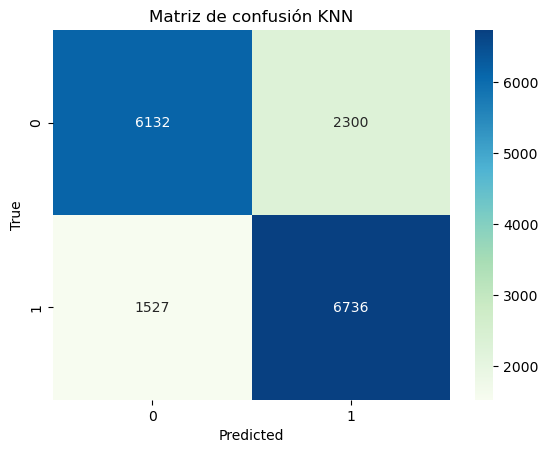

In [175]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión KNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Como podemos observar, los hiperparametros mejoraron considerablemente el f1 score, sin embargo no es un valor muy alto. Vamos a probar con otros modelos para ver si podemos mejorar este valor.

A continuacion, vamos a ver como se comporta nuestro modelo con los datos de train para analizar si hubo overfitting o no.


In [176]:
y_predict_train = knn_hiperparams.predict(x_train.values)
mostrar_scores(y_train, y_predict_train)

Accuracy: 0.9963547683224233
Recall: 0.9944502074688797
Precision: 0.9981778425655977
f1 score: 0.9963105383496155


Claramente hubo overfitting, debido a que la cantidad de vecinos más cercanos es muy baja, y por lo tanto, el modelo se ajusta muy bien a los datos de entrenamiento. Podria argumentarse que es por un valor de k muy bajo, sin embargo según investigaciones nuestras, un buen valor de k sería la raíz cuadrada del total de samples que tiene nuestro dataset dividido dos. Además, cabe recalcar que tanto la cantidad de clases como la cantidad de caracteristicas de nuestro dataset no deberían tener un rol importante a la hora de determinar nuestro k.


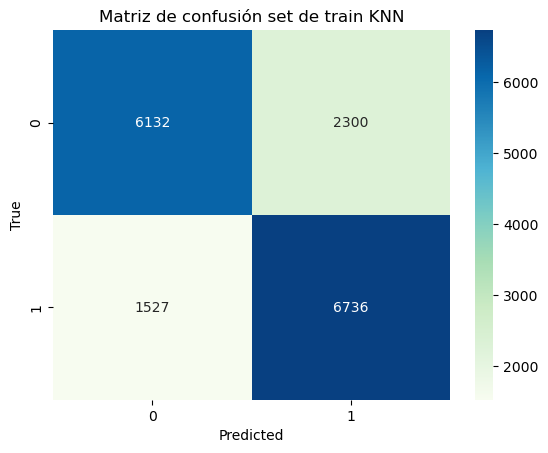

In [177]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión set de train KNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Ahora vamos a porbar con una cantidad de vecinos mas elevada

In [178]:
cantidad = df_ensambles.shape[0]
vecinos = int(np.sqrt(cantidad))//2

knn_vecinos_alta = KNeighborsClassifier(n_neighbors=vecinos, weights='distance', algorithm='kd_tree', metric='manhattan')

knn_vecinos_alta.fit(x_train.values, y_train)
y_pred = knn_hiperparams.predict(x_test.values)
mostrar_scores(y_test, y_pred)

Accuracy: 0.7707696915244086
Recall: 0.8152002904514098
Precision: 0.7454625940681717
f1 score: 0.778773339499393


In [179]:
y_predict_train = knn_vecinos_alta.predict(x_train.values)
mostrar_scores(y_train, y_predict_train)

Accuracy: 0.9964574509048902
Recall: 0.9954356846473029
Precision: 0.9974015175137719
f1 score: 0.9964176314833083


Podemos observar que esto tampoco logro reducir el overfit.

### SVM


Para continuar, vamos a crear un modelo de support vector machine para ver que tan bien puede predecir nuestra variable target.


In [180]:
df_a_utilizar = df_ensambles.copy()

In [181]:
columns = [
    'hotel',
    'lead_time',
    'year',
    'week_number',
    'meal_type',
    'country',
    'market_segment',
    'is_repeated_guest',
    'previous_cancellations',
    'booking_changes',
    'deposit_type',
    'agent_id',
    'days_in_waiting_list',
    'customer_type',
    'average_daily_rate',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'is_canceled',
    'total_people'
]

dummy_columns = [
    'hotel',
    'deposit_type',
    'market_segment',
    'agent_id',
    'country',
    'customer_type',
    'meal_type',
]



In [182]:
agentes = df_a_utilizar[['agent_id']].value_counts().reset_index()

agentes.columns = ['agent_id', 'cantidad']
agentes_mayoritarios = agentes[agentes['cantidad'] > 20]
agentes_minoritarios = agentes[agentes['cantidad'] <= 20]

df_agentes_mayoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_mayoritarios['agent_id'])]
df_agentes_minoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id'])]
df_agentes_minoritarios.loc[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id']), 'agent_id'] = 'Otros'

df_agentes = pd.concat([df_agentes_mayoritarios, df_agentes_minoritarios])

paises = df_agentes[['country']].value_counts().reset_index()
paises.columns = ['country', 'cantidad']
paises_mayoritarios = paises[paises['cantidad'] > 15]
paises_minoritarios = paises[paises['cantidad'] <= 15]

df_paises_mayoritarios = df_agentes[df_agentes['country'].isin(paises_mayoritarios['country'])]
df_paises_minoritarios = df_agentes[df_agentes['country'].isin(paises_minoritarios['country'])]
df_paises_minoritarios.loc[df_agentes['country'].isin(paises_minoritarios['country']), 'country'] = 'Otros'

df_encode = pd.concat([df_paises_mayoritarios, df_paises_minoritarios])

filtrado = df_encode[columns]

df_con_dummies = pd.get_dummies(filtrado, columns=dummy_columns, drop_first=True)


df_con_dummies['cuarto_correcto'] = df_ensambles['reserved_room_type'] == df_ensambles['assigned_room_type']
df_con_dummies['cuarto_correcto'] = df_con_dummies['cuarto_correcto'].apply(lambda x: 1 if x == True else 0)

df_trabajo_x = df_con_dummies.drop(['is_canceled'], axis='columns', inplace=False)
df_trabajo_y = df_con_dummies['is_canceled'].copy()

In [183]:
x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=11457,
                                                    stratify=df_con_dummies["is_canceled"].values
                                                    )

In [184]:
svm = SVC()

svm.fit(x_train, y_train)

y_pred = svm.predict(x_test)
mostrar_scores(y_pred, y_test)

Accuracy: 0.6117400419287212
Recall: 0.6358919578818861
Precision: 0.5042962604380975
f1 score: 0.5625


Como podemos ver el f1 score es muy bajo, esto puede ser debido a que as variables no estan normalizadas, vamos a intentar con un min-max sclaer y con una normalizacion gaussiana para ver cual obtiene mejores resultados

In [185]:
min_max = preprocessing.MinMaxScaler()
x_train_minmax = min_max.fit_transform(x_train)
x_test_minmax = min_max.transform(x_test)

normal = preprocessing.StandardScaler()
x_train_normal = normal.fit_transform(x_train)
x_test_normal = normal.transform(x_test)

In [186]:
svm_minmax = SVC(random_state=33)

svm_minmax.fit(x_train_minmax, y_train)

y_pred = svm_minmax.predict(x_test_minmax)
mostrar_scores(y_pred, y_test)

Accuracy: 0.8497154836777479
Recall: 0.8336038961038961
Precision: 0.8700229940699504
f1 score: 0.8514241724403387


Al usar una normalizacion por minimos y maximos el f1 score mejoro considerablemente, a continuacion vamos a probar con una normalizacion mediante una distribucion normal

In [187]:
svm_normal = SVC(random_state=33)

svm_normal.fit(x_train_normal, y_train)

y_pred = svm_normal.predict(x_test_normal)
mostrar_scores(y_pred, y_test)

Accuracy: 0.8362383947289608
Recall: 0.8261177303291258
Precision: 0.847513009802735
f1 score: 0.8366786140979688


Como podemos ver, la normalizacion por minimos y maximos fue considerablemente mejor, es por eso que nos vamos a quedar con el escalado de los datos mediante minimos y maximos.

Ahora vamos a intentar variar el kernel y parametros para ver si podemos mejorar el scoring.

##### Kernel Polinomial

In [188]:
svm_poly = SVC(kernel='poly', random_state=33)

svm_poly.fit(x_train_minmax, y_train)

y_pred = svm_poly.predict(x_test_minmax)
mostrar_scores(y_pred, y_test)

Accuracy: 0.8487571129080563
Recall: 0.8335270867240177
Precision: 0.8677235870749123
f1 score: 0.8502816483842277


In [189]:
svm_poly_cuadratica = SVC(kernel='poly', degree=2, random_state=33)

svm_poly_cuadratica.fit(x_train_minmax, y_train)

y_pred = svm_poly_cuadratica.predict(x_test_minmax)
mostrar_scores(y_pred, y_test)

Accuracy: 0.8440850554058101
Recall: 0.8292228943694742
Precision: 0.8626406874016701
f1 score: 0.8456017557387746


In [190]:
svm_poly_5 = SVC(kernel='poly', degree=5, random_state=33)

svm_poly_5.fit(x_train_minmax, y_train)

y_pred = svm_poly_5.predict(x_test_minmax)
mostrar_scores(y_pred, y_test)

Accuracy: 0.8539083557951482
Recall: 0.8384472338447234
Precision: 0.8730485295897373
f1 score: 0.8553981146617655


Como este fue nuestro mejor modelo SVM vamos a analizarlo un poco mas a detalle.

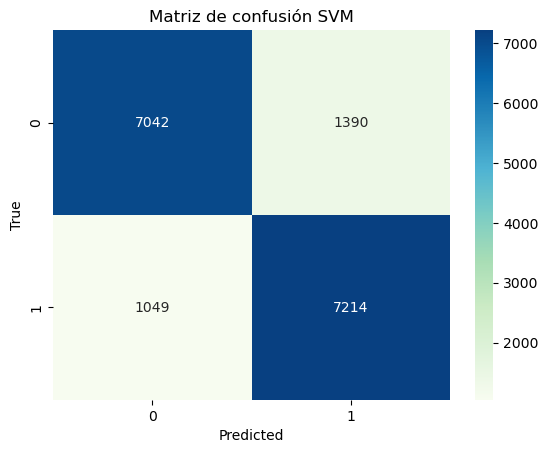

In [191]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión SVM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Luego veremos como se comporta nuestro modelo con el dataset que entrenó para ver si hubo underfitting u overfitting.

In [192]:
y_pred_train = svm_poly_5.predict(x_train_minmax)
mostrar_scores(y_pred_train, y_train)

Accuracy: 0.8694904376845077
Recall: 0.8547226386806597
Precision: 0.8870850622406639
f1 score: 0.8706032069228812


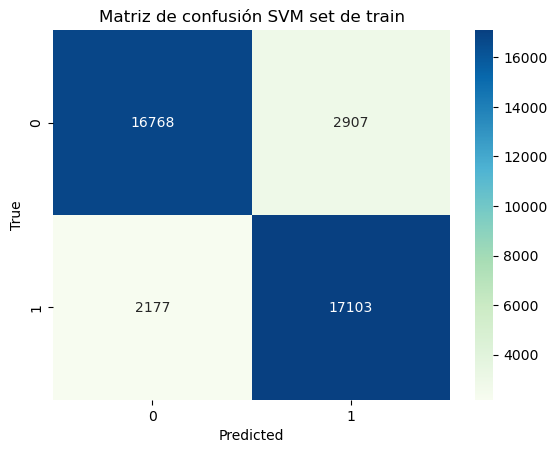

In [193]:
tabla = confusion_matrix(y_train, y_pred_train)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión SVM set de train')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

##### Kernel Sigmoide

In [195]:
svm_sigmoide = SVC(kernel='sigmoid')

svm_sigmoide.fit(x_train_minmax, y_train)

y_pred = svm_sigmoide.predict(x_test_minmax)
mostrar_scores(y_pred, y_test)

Accuracy: 0.6422282120395328
Recall: 0.6375871184811344
Precision: 0.6421396587195933
f1 score: 0.6398552909255351


In [196]:
svm_sigmoide_gamma = SVC(kernel='sigmoid', gamma='auto')

svm_sigmoide_gamma.fit(x_train_minmax, y_train)

y_pred = svm_sigmoide_gamma.predict(x_test_minmax)
mostrar_scores(y_pred, y_test)

Accuracy: 0.8142557651991614
Recall: 0.8019419747309312
Precision: 0.8296018395255961
f1 score: 0.8155374457200643


El kernel sigmoide a pesar de haber obtenido un mejor fs score con el gamma en auto, sigue sin ser mejor que el kernel polinomial.

##### Kernel Lineal

In [197]:
svm_lin = SVC(kernel='linear', random_state=33)

svm_lin.fit(x_train_minmax, y_train)
y_pred = svm_lin.predict(x_test_minmax)
mostrar_scores(y_pred, y_test)

Accuracy: 0.8249775381850853
Recall: 0.8119378577269011
Precision: 0.8412198959215781
f1 score: 0.8263195435092724


Como podemos ver, luego de intentar varios kernels con varios parametros diferentes, el modelo que mejor resulto para predecir nuestra variable target fue el kernel polinomial con grado 5. Por lo tanto vamos a utilizar ese modelo para los ensambles hibridos mas tarde.

### RandomForest


In [198]:
df_a_utilizar = df_ensambles.copy()

#### RandomForest Basico


Utilizamos todas las features del dataset para entrenar el modelo. Luego, vamos a ir variando las features para ver si mejora o empeora nuestro clasificador.


In [199]:
columns = [
    'hotel',
    'lead_time',
    'year',
    'month',
    'week_number',
    'day_of_month',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'adults',
    'children',
    'babies',
    'meal_type',
    'country',
    'market_segment',
    'distribution_channel',
    'is_repeated_guest',
    'previous_cancellations',
    'previous_bookings_not_canceled',
    'reserved_room_type',
    'assigned_room_type',
    'booking_changes',
    'deposit_type',
    'agent_id',
    'days_in_waiting_list',
    'customer_type',
    'average_daily_rate',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'is_canceled',
    'total_nights',
    'total_people'
]

filtrado = df_a_utilizar[columns]

dummy_columns = ['hotel', 'deposit_type', 'market_segment', 'agent_id', 'country', 'customer_type',
                 'meal_type', 'reserved_room_type', 'assigned_room_type', 'distribution_channel', 'month', 'year']
df_con_dummies = pd.get_dummies(filtrado, columns=dummy_columns, drop_first=True)

df_trabajo_x = df_con_dummies.drop(['is_canceled'], axis='columns', inplace=False)
df_trabajo_y = df_con_dummies['is_canceled'].copy()


x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=11457,
                                                    stratify=df_con_dummies[target].values
                                                    )

Primero, vamos a probar con un random forest con pocos parametros. Luego, vamos a realizar una busqueda de hiperparametros para ver si podemos mejorar el modelo.


In [200]:
random_forest_basico = RandomForestClassifier(max_depth=20, random_state=33, n_estimators=50, n_jobs=-1)
random_forest_basico.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 33,
 'verbose': 0,
 'warm_start': False}

In [201]:
modelo = random_forest_basico.fit(X=x_train, y=y_train)
y_pred = modelo.predict(x_test)
mostrar_scores(y_test, y_pred)

Accuracy: 0.8646301287810721
Recall: 0.8544112307878494
Precision: 0.8697794751755574
f1 score: 0.862026862026862


Ya de por si el random forest nos dio un resultado relativamente alto comparado a los otros modelos de ensambles, vamos a ver si podemos mejorar este puntaje con hiperparametros y seleccionando variables

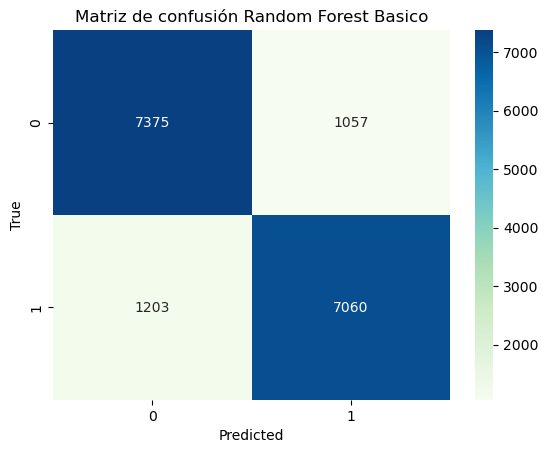

In [202]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión Random Forest Basico')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [203]:
y_predict_train = modelo.predict(x_train)
mostrar_scores(y_train, y_predict_train)

Accuracy: 0.9178539340264408
Recall: 0.9235477178423237
Precision: 0.9116321933237763
f1 score: 0.9175512728022261


Hay un leve overfit pero esto no deberia preocuparnos en este momento, ya que este es el modelo de RandomForest mas basico que vamos a utilizar. A continuacion vamos a probar con un modelo mas complejo para ver si podemos mejorar el puntaje.

#### RandomForest Mejorado


Vamos a filtrar variables de manera que nuestro modelo de ensamble RandomForest mejore su predicción.

In [204]:
columns = [
    'hotel',
    'lead_time',
    'year',
    'week_number',
    'meal_type',
    'country',
    'market_segment',
    'is_repeated_guest',
    'previous_cancellations',
    'booking_changes',
    'deposit_type',
    'agent_id',
    'days_in_waiting_list',
    'customer_type',
    'average_daily_rate',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'is_canceled',
    'total_people'
]

dummy_columns = [
    'hotel',
    'deposit_type',
    'market_segment',
    'agent_id',
    'country',
    'customer_type',
    'meal_type',
]

In [205]:
agentes = df_a_utilizar[['agent_id']].value_counts().reset_index()

agentes.columns = ['agent_id', 'cantidad']
agentes_mayoritarios = agentes[agentes['cantidad'] > 20]
agentes_minoritarios = agentes[agentes['cantidad'] <= 20]

df_agentes_mayoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_mayoritarios['agent_id'])]
df_agentes_minoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id'])]
df_agentes_minoritarios.loc[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id']), 'agent_id'] = 'Otros'

df_agentes = pd.concat([df_agentes_mayoritarios, df_agentes_minoritarios])

paises = df_agentes[['country']].value_counts().reset_index()
paises.columns = ['country', 'cantidad']
paises_mayoritarios = paises[paises['cantidad'] > 15]
paises_minoritarios = paises[paises['cantidad'] <= 15]

df_paises_mayoritarios = df_agentes[df_agentes['country'].isin(paises_mayoritarios['country'])]
df_paises_minoritarios = df_agentes[df_agentes['country'].isin(paises_minoritarios['country'])]
df_paises_minoritarios.loc[df_agentes['country'].isin(paises_minoritarios['country']), 'country'] = 'Otros'

df_encode = pd.concat([df_paises_mayoritarios, df_paises_minoritarios])

filtrado = df_encode[columns]

df_con_dummies = pd.get_dummies(filtrado, columns=dummy_columns, drop_first=True)

df_con_dummies['cuarto_correcto'] = df_ensambles['reserved_room_type'] == df_ensambles['assigned_room_type']
df_con_dummies['cuarto_correcto'] = df_con_dummies['cuarto_correcto'].apply(lambda x: 1 if x == True else 0)

df_trabajo_x = df_con_dummies.drop(['is_canceled'], axis='columns', inplace=False)
df_trabajo_y = df_con_dummies['is_canceled'].copy()

Vamos a realizar un filtrado tal como hicimos antes con los arboles de decisión ya que, como las variables agent_id y country pueden tomar demasiados valores distintos, existe la posibilidad de que el modelo tenga un nodo de decision con un valor que no existe en el dataset de test o viceversa.


In [206]:
x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=11457,
                                                    stratify=df_con_dummies[target].values
                                                    )

In [207]:
random_forest_mejorado = RandomForestClassifier(criterion='entropy',
                                                max_depth=25,
                                                min_samples_leaf=1,
                                                n_estimators=100,
                                                random_state=13,
                                                n_jobs=-1,
                                                max_features='sqrt',
                                                class_weight='balanced_subsample',
                                                )
random_forest_mejorado.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'entropy',
 'max_depth': 25,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 13,
 'verbose': 0,
 'warm_start': False}

Usamos un escalador ya que no afecta nuestro árbol, pero si afecta a los ensambles híbridos que vamos a realizar más adelante. Esto se debe a que los ensambles híbridos utilizan el support vector machine como clasificador, y este necesita que los datos esten escalados para poder funcionar correctamente.

In [208]:
min_max = preprocessing.MinMaxScaler()
x_train_minmax = min_max.fit_transform(x_train)
x_test_minmax = min_max.transform(x_test)


modelo = random_forest_mejorado.fit(X=x_train_minmax, y=y_train)
y_pred = modelo.predict(x_test_minmax)
mostrar_scores(y_test, y_pred)

Accuracy: 0.8766097634022162
Recall: 0.8852716930896769
Precision: 0.8680431944938887
f1 score: 0.8765727980826843


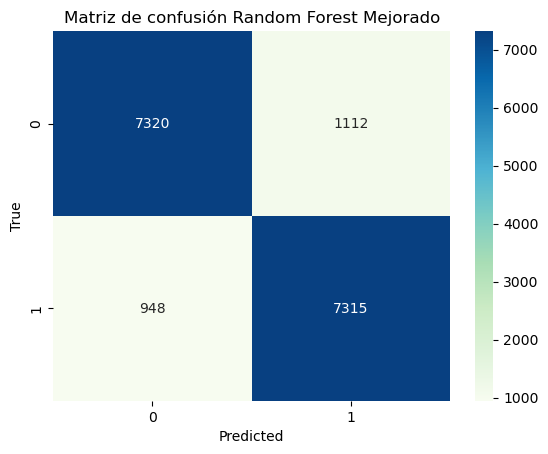

In [209]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión Random Forest Mejorado')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [210]:
y_predict_train = modelo.predict(x_train_minmax)
mostrar_scores(y_train, y_predict_train)

Accuracy: 0.9373379540495443
Recall: 0.958402489626556
Precision: 0.9185266192772282
f1 score: 0.9380409675863645


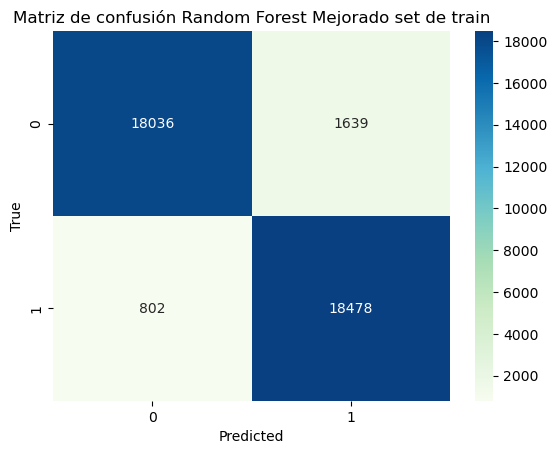

In [211]:
tabla = confusion_matrix(y_train, y_predict_train)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión Random Forest Mejorado set de train')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Es normal que un random forest se overfitee un poco, por lo tanto, no nos deberia alarmar esta metrica. Es por esto que por ejemplo no utilicemos poda, para que nuestro arbol se extienda lo maximo posible. Ademas, el bootstraping y el bagging tambien ayudan a que el overfit no genere problemas ya que por cada arbol se toman distintos samples de datos.


Para la busqueda de hiperparametros vamos a dejar un numero de iteraciones bajo, pero anteriormente ya habiamos probado con un numero de iteraciones mas alto y guardamos los resultados. Por lo tanto, vamos a dejarlo en 10 para que la busqueda sea mas rapida.

In [214]:
from sklearn.model_selection import RandomizedSearchCV

randomforest_cv = RandomForestClassifier(max_features='sqrt', oob_score=True, random_state=1, n_jobs=-1)
iteraciones = 25

param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 15, 20, 25, 30],
    'min_samples_leaf': [1, 2, 4, 8, 16],
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample']
}

rf_randomCV = RandomizedSearchCV(estimator=randomforest_cv, param_distributions=param_grid, cv=6, verbose=2, n_jobs=2, random_state=33, n_iter=iteraciones)
rf_randomCV.fit(x_train, y_train)
rf_randomCV.best_params_


Fitting 6 folds for each of 25 candidates, totalling 150 fits
[CV] END class_weight=balanced_subsample, max_depth=30, max_features=log2, min_samples_leaf=1, n_estimators=100; total time=   3.4s
[CV] END class_weight=balanced_subsample, max_depth=30, max_features=log2, min_samples_leaf=1, n_estimators=100; total time=   3.5s
[CV] END class_weight=balanced_subsample, max_depth=30, max_features=log2, min_samples_leaf=1, n_estimators=100; total time=   3.1s
[CV] END class_weight=balanced_subsample, max_depth=30, max_features=log2, min_samples_leaf=1, n_estimators=100; total time=   3.2s
[CV] END class_weight=balanced_subsample, max_depth=30, max_features=log2, min_samples_leaf=1, n_estimators=100; total time=   2.8s
[CV] END class_weight=balanced_subsample, max_depth=30, max_features=log2, min_samples_leaf=1, n_estimators=100; total time=   2.8s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_leaf=4, n_estimators=200; total time=   3.6s
[CV] END class_weight=ba

/Users/juampi/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
72 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/juampi/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/juampi/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/juampi/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "/U

{'n_estimators': 300,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 30,
 'class_weight': 'balanced'}

In [215]:
modelo = rf_randomCV.best_estimator_
y_pred = modelo.predict(x_test)
mostrar_scores(y_test, y_pred)

Accuracy: 0.8779275232105421
Recall: 0.8845455645649279
Precision: 0.8708447515786966
f1 score: 0.8776416906820366


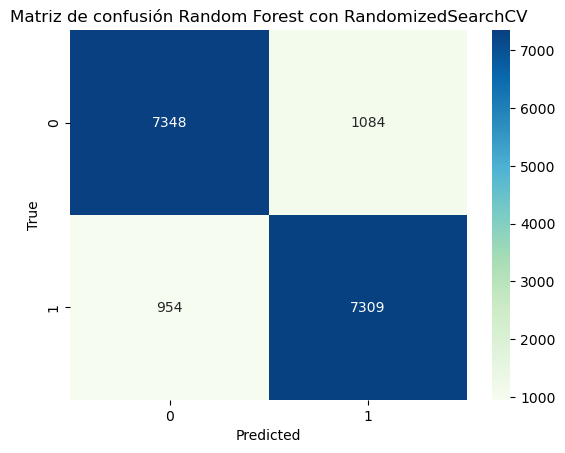

In [216]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión Random Forest con RandomizedSearchCV')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [217]:
y_predict_train = modelo.predict(x_train)
mostrar_scores(y_train, y_predict_train)

Accuracy: 0.9526119881915031
Recall: 0.9742219917012448
Precision: 0.9329922511424598
f1 score: 0.9531614736628439


Con esto buscamos los mejores hiperparametros para nuestro random forest. Evitamos que los arboles se poden ya que esto no es beneficioso para los mismos.

## XGBoost

Ahora vamos a probar con otro tipo de ensamble el cual es parecido al RandomForest pero es una version "mejorada". Tiene la caracteristica que es muy eficiente con grandes volúmenes de datos, tal como en este caso.

In [218]:
columns = [
    'hotel',
    'lead_time',
    'year',
    'week_number',
    'meal_type',
    'country',
    'market_segment',
    'is_repeated_guest',
    'previous_cancellations',
    'booking_changes',
    'deposit_type',
    'agent_id',
    'days_in_waiting_list',
    'customer_type',
    'average_daily_rate',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'is_canceled',
    'total_people'
]

dummy_columns = [
    'hotel',
    'deposit_type',
    'market_segment',
    'agent_id',
    'country',
    'customer_type',
    'meal_type',
]

In [219]:
agentes = df_a_utilizar[['agent_id']].value_counts().reset_index()

agentes.columns = ['agent_id', 'cantidad']
agentes_mayoritarios = agentes[agentes['cantidad'] > 20]
agentes_minoritarios = agentes[agentes['cantidad'] <= 20]

df_agentes_mayoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_mayoritarios['agent_id'])]
df_agentes_minoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id'])]
df_agentes_minoritarios.loc[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id']), 'agent_id'] = 'Otros'

df_agentes = pd.concat([df_agentes_mayoritarios, df_agentes_minoritarios])

paises = df_agentes[['country']].value_counts().reset_index()
paises.columns = ['country', 'cantidad']
paises_mayoritarios = paises[paises['cantidad'] > 15]
paises_minoritarios = paises[paises['cantidad'] <= 15]

df_paises_mayoritarios = df_agentes[df_agentes['country'].isin(paises_mayoritarios['country'])]
df_paises_minoritarios = df_agentes[df_agentes['country'].isin(paises_minoritarios['country'])]
df_paises_minoritarios.loc[df_agentes['country'].isin(paises_minoritarios['country']), 'country'] = 'Otros'

df_encode = pd.concat([df_paises_mayoritarios, df_paises_minoritarios])

filtrado = df_encode[columns]

df_con_dummies = pd.get_dummies(filtrado, columns=dummy_columns, drop_first=True)


df_con_dummies['cuarto_correcto'] = df_ensambles['reserved_room_type'] == df_ensambles['assigned_room_type']
df_con_dummies['cuarto_correcto'] = df_con_dummies['cuarto_correcto'].apply(lambda x: 1 if x == True else 0)

df_trabajo_x = df_con_dummies.drop(['is_canceled'], axis='columns', inplace=False)
df_trabajo_y = df_con_dummies['is_canceled'].copy()

Utilizamos este rango de columnas para ir filtrando con el objetivo de que nuestro modelo mejore.

Realizamos el mismo filtrados que en el random forest ya uqe notamos uqe con los arboles de decision nos dieron muy buenos resultados.

In [220]:
target = 'is_canceled'
x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=11457,
                                                    stratify=df_con_dummies[target].values
                                                    )

In [221]:
import xgboost as xgb

dtrain_clf = xgb.DMatrix(x_train, y_train)
dtest_clf = xgb.DMatrix(x_test, y_test)

In [222]:
iteraciones = 15
param_grid = {
    'max_depth': [3, 5, 10, 15, 20, 25, 30],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [100, 200, 300, 400, 500],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [0, 1, 2, 3, 4, 5],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_lambda': [0.1, 0.2, 0.3, 0.4]
}

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', random_state=33, n_jobs=-1)

xgb_randomCV = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_grid, cv=5, n_jobs=-1, random_state=33, n_iter=iteraciones)
xgb_randomCV.fit(x_train, y_train)
xgb_randomCV.best_params_

{'subsample': 0.6,
 'reg_lambda': 0.3,
 'reg_alpha': 0,
 'n_estimators': 500,
 'min_child_weight': 0,
 'max_depth': 10,
 'learning_rate': 0.05,
 'gamma': 0.3,
 'colsample_bytree': 0.5}

Utilizamos un poco menos de folds porque esta busqueda de hiperparametros es muy costosa.

In [223]:
y_pred = xgb_randomCV.predict(x_test)
mostrar_scores(y_test, y_pred)

Accuracy: 0.8808026355196167
Recall: 0.887813142926298
Precision: 0.8734373139659484
f1 score: 0.8805665586364183


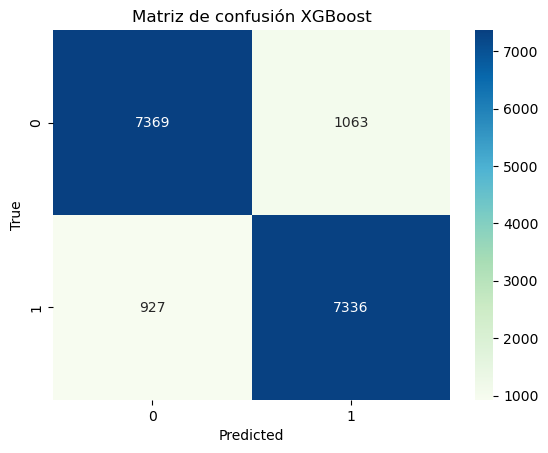

In [224]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión XGBoost')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Vemos como se comporta con los datos de entrenamiento.

In [225]:
y_pred_train = xgb_randomCV.predict(x_train)
mostrar_scores(y_train, y_pred_train)

Accuracy: 0.9482736490822744
Recall: 0.9573132780082988
Precision: 0.9393353351315589
f1 score: 0.948239101954841


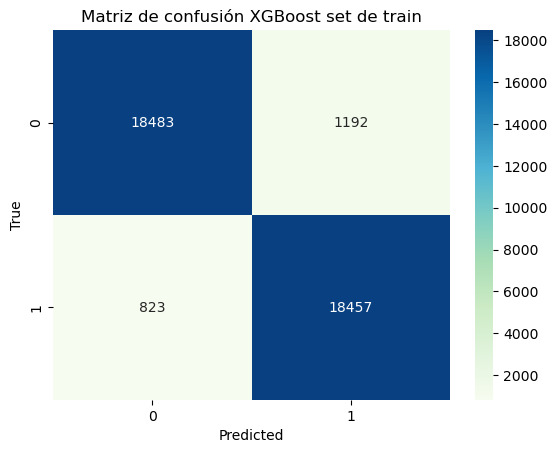

In [226]:
tabla = confusion_matrix(y_train, y_pred_train)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión XGBoost set de train')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

A continuacion probamos otro modelo de XGBoost pero con muchos estimadores para ver como se comporta. Creemos que este modelo va a tener un overfitting muy grande, pero vamos a probarlo igual para ver que resultados obtenemos.

In [227]:
import xgboost as xgb

min_max = preprocessing.MinMaxScaler()
x_train_minmax = min_max.fit_transform(x_train)
x_test_minmax = min_max.transform(x_test)


xgb_model = xgb.XGBClassifier(n_estimators=1000, eta=0.04,
                              max_depth=8, min_child_weight=1, colsample_bytree=0.8,  seed=27)
xgb_model.fit(x_train_minmax, y_train)
y_pred = xgb_model.predict(x_test_minmax)
mostrar_scores(y_test, y_pred)

Accuracy: 0.8755315962863133
Recall: 0.8840614788817621
Precision: 0.8670623145400593
f1 score: 0.8754793863854267


In [228]:
y_predict_train = xgb_model.predict(x_train_minmax)
mostrar_scores(y_train, y_predict_train)

Accuracy: 0.9114106019766397
Recall: 0.9195539419087136
Precision: 0.9032044424066432
f1 score: 0.9113058675370738


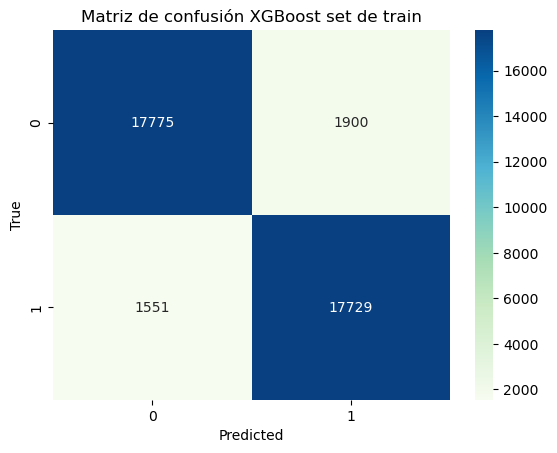

In [229]:
tabla = confusion_matrix(y_train, y_predict_train)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión XGBoost set de train')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Como se puede observar este modelo tambien esta levemente sobreentrenado. Sin embargo, en el submit de kaggle dió bastante alto, pero, quizas cuando se vean los resultados de la tabla privada ahi se puede notar el problema del overfit, ya que en ese caso se predice un volumen más alto de datos.

## Stacking


Ahora vamos a probar los ensambles hibridos con nuestros modelos previamente entrenados. Vamos a quedarnos con los mejores modelos de cada tipo de ensamble para ver que resultados obtenemos.

In [230]:
df_a_utilizar = df_ensambles.copy()

In [231]:
columns = [
    'hotel',
    'lead_time',
    'year',
    'week_number',
    'meal_type',
    'country',
    'market_segment',
    'is_repeated_guest',
    'previous_cancellations',
    'booking_changes',
    'deposit_type',
    'agent_id',
    'days_in_waiting_list',
    'customer_type',
    'average_daily_rate',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'is_canceled',
    'total_people'
]

filtrado = df_encode[columns]

dummy_columns = [
    'hotel',
    'deposit_type',
    'market_segment',
    'agent_id',
    'country',
    'customer_type',
    'meal_type',
]

In [232]:
agentes = df_a_utilizar[['agent_id']].value_counts().reset_index()

agentes.columns = ['agent_id', 'cantidad']
agentes_mayoritarios = agentes[agentes['cantidad'] > 20]
agentes_minoritarios = agentes[agentes['cantidad'] <= 20]

df_agentes_mayoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_mayoritarios['agent_id'])]
df_agentes_minoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id'])]
df_agentes_minoritarios.loc[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id']), 'agent_id'] = 'Otros'

df_agentes = pd.concat([df_agentes_mayoritarios, df_agentes_minoritarios])

paises = df_agentes[['country']].value_counts().reset_index()
paises.columns = ['country', 'cantidad']
paises_mayoritarios = paises[paises['cantidad'] > 15]
paises_minoritarios = paises[paises['cantidad'] <= 15]

df_paises_mayoritarios = df_agentes[df_agentes['country'].isin(paises_mayoritarios['country'])]
df_paises_minoritarios = df_agentes[df_agentes['country'].isin(paises_minoritarios['country'])]
df_paises_minoritarios.loc[df_agentes['country'].isin(paises_minoritarios['country']), 'country'] = 'Otros'

df_encode = pd.concat([df_paises_mayoritarios, df_paises_minoritarios])

filtrado = df_encode[columns]

df_con_dummies = pd.get_dummies(filtrado, columns=dummy_columns, drop_first=True)


df_con_dummies['cuarto_correcto'] = df_ensambles['reserved_room_type'] == df_ensambles['assigned_room_type']
df_con_dummies['cuarto_correcto'] = df_con_dummies['cuarto_correcto'].apply(lambda x: 1 if x == True else 0)

df_trabajo_x = df_con_dummies.drop(['is_canceled'], axis='columns', inplace=False)
df_trabajo_y = df_con_dummies['is_canceled'].copy()

In [233]:

x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=11457,
                                                    stratify=df_con_dummies[target].values
                                                    )

Al final, el ensamble híbrido nos da mejores resultados sin el SVM, pero de todas maneras conservamos el escalador ya que no afecta a los árboles de decisión, pero ya fueron entrenados con el escalador.

In [234]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

min_max = preprocessing.MinMaxScaler()
x_train_minmax = min_max.fit_transform(x_train)
x_test_minmax = min_max.transform(x_test)

estimadores = [
  ("random forest", random_forest_mejorado),
  ("xg boost", xgb_model),
]

log_model = LogisticRegression(random_state=33, max_iter=1000, n_jobs=-1, penalty='l2', C=0.1)

stacking_model = StackingClassifier(estimators=estimadores,
                                    passthrough=True,
                                    final_estimator=log_model,
                                    cv='prefit',
                                    verbose=2, 
                                    
                                    n_jobs=-1)

stacking_model.fit(x_train_minmax, y_train)
y_pred = stacking_model.predict(x_test_minmax)
mostrar_scores(y_test, y_pred)

Accuracy: 0.8791853848457623
Recall: 0.8743797652184436
Precision: 0.8806679668454412
f1 score: 0.8775126009594948


Decidimos utilizar una regresion logística como metamodelo ya que es un modelo simple y que no requiere de muchos recursos para entrenar. Además, es un modelo que se puede utilizar para clasificación binaria y según nuestras investigaciones tiene un gran rendimiento en este tipo de rol en el ensamble.

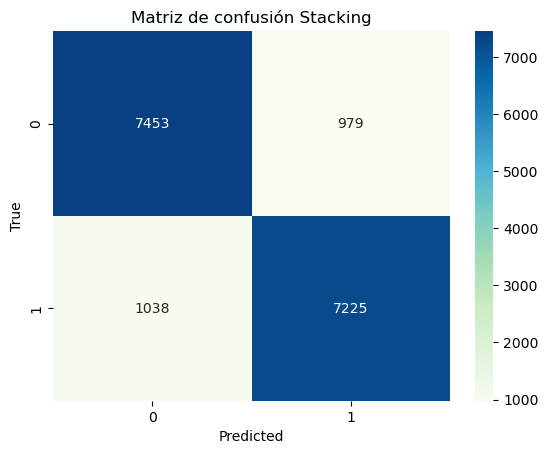

In [235]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión Stacking')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Luego veremos como se comporta con los datos de entrenamiento.

In [236]:
y_predict_train = stacking_model.predict(x_train_minmax)
mostrar_scores(y_train, y_predict_train)

Accuracy: 0.9433448851238608
Recall: 0.9514522821576763
Precision: 0.9352026510323732
f1 score: 0.9432574881090114


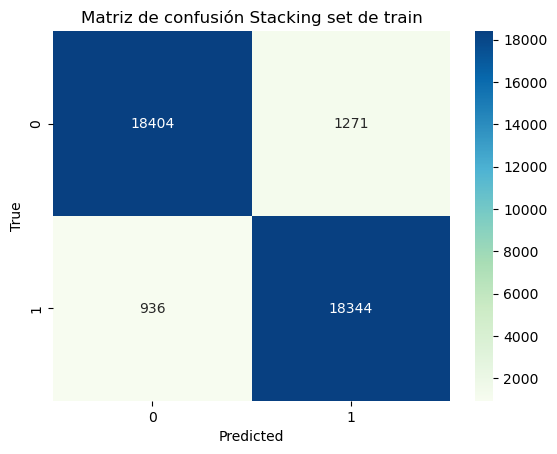

In [237]:
tabla = confusion_matrix(y_train, y_predict_train)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión Stacking set de train')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Podemos ver que presenta un leve overfit, pero es esperable ya que los estimadores usados también presentaban un pequeño overfit.

Ahora vamos a intentar realizar un stacking conformado por unicamente random forests para ver si podemos mejorar el puntaje.

In [238]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimadores = []

x_train_stacking, x_test_stacking, y_train_stacking, y_test_stacking = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=1,
                                                    stratify=df_con_dummies[target].values
                                                    )

for i in range(1, 11):
    d = random.randint(20, 50)
    n = random.randint(100, 500)
    x_train, x_test, y_train, y_test = train_test_split(x_train_stacking,
                                                        y_train_stacking,
                                                        test_size=0.3,
                                                        random_state=d,
                                                        )
    rf = RandomForestClassifier(criterion='entropy', max_depth=d, min_samples_leaf=1, n_estimators=n, random_state=13, n_jobs=-1, max_features='sqrt')
    modelo = rf.fit(x_train, y_train)
    estimadores.append(("random forest " + str(i), modelo))

log_model = LogisticRegression(random_state=33, max_iter=1000, n_jobs=-1, solver="newton-cholesky", penalty='l2', C=0.1)

stacking_model = StackingClassifier(estimators=estimadores,
                                    passthrough=True,
                                    final_estimator=log_model,
                                    cv='prefit',
                                    verbose=2, 
                                    n_jobs=-1)

modelo = stacking_model.fit(x_train_stacking, y_train_stacking)
y_pred = modelo.predict(x_test_stacking)
mostrar_scores(y_test_stacking, y_pred)

Accuracy: 0.8772087451332734
Recall: 0.86590826576304
Precision: 0.8836606150426084
f1 score: 0.8746943765281173


In [239]:
y_predict_train = modelo.predict(x_train_stacking)
mostrar_scores(y_train_stacking, y_predict_train)

Accuracy: 0.9819792067770504
Recall: 0.9815871369294605
Precision: 0.9819946035699461
f1 score: 0.9817908279726084


## Voting

Ahora vamos a probar con el metodo de Voting para ver que resultados obtenemos, lo esperado es que sea levemente inferior al de Stacking.

In [240]:
columns = [
    'hotel',
    'lead_time',
    'year',
    'week_number',
    'meal_type',
    'country',
    'market_segment',
    'is_repeated_guest',
    'previous_cancellations',
    'booking_changes',
    'deposit_type',
    'agent_id',
    'days_in_waiting_list',
    'customer_type',
    'average_daily_rate',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'is_canceled',
    'total_people'
]

dummy_columns = [
    'hotel',
    'deposit_type',
    'market_segment',
    'agent_id',
    'country',
    'customer_type',
    'meal_type',
]

In [241]:
agentes = df_a_utilizar[['agent_id']].value_counts().reset_index()

agentes.columns = ['agent_id', 'cantidad']
agentes_mayoritarios = agentes[agentes['cantidad'] > 20]
agentes_minoritarios = agentes[agentes['cantidad'] <= 20]

df_agentes_mayoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_mayoritarios['agent_id'])]
df_agentes_minoritarios = df_a_utilizar[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id'])]
df_agentes_minoritarios.loc[df_a_utilizar['agent_id'].isin(agentes_minoritarios['agent_id']), 'agent_id'] = 'Otros'

df_agentes = pd.concat([df_agentes_mayoritarios, df_agentes_minoritarios])

paises = df_agentes[['country']].value_counts().reset_index()
paises.columns = ['country', 'cantidad']
paises_mayoritarios = paises[paises['cantidad'] > 15]
paises_minoritarios = paises[paises['cantidad'] <= 15]

df_paises_mayoritarios = df_agentes[df_agentes['country'].isin(paises_mayoritarios['country'])]
df_paises_minoritarios = df_agentes[df_agentes['country'].isin(paises_minoritarios['country'])]
df_paises_minoritarios.loc[df_agentes['country'].isin(paises_minoritarios['country']), 'country'] = 'Otros'

df_encode = pd.concat([df_paises_mayoritarios, df_paises_minoritarios])

filtrado = df_encode[columns]

df_con_dummies = pd.get_dummies(filtrado, columns=dummy_columns, drop_first=True)


df_con_dummies['cuarto_correcto'] = df_ensambles['reserved_room_type'] == df_ensambles['assigned_room_type']
df_con_dummies['cuarto_correcto'] = df_con_dummies['cuarto_correcto'].apply(lambda x: 1 if x == True else 0)

df_trabajo_x = df_con_dummies.drop(['is_canceled'], axis='columns', inplace=False)
df_trabajo_y = df_con_dummies['is_canceled'].copy()

In [242]:
x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x,
                                                    df_trabajo_y,
                                                    test_size=0.3,
                                                    random_state=11457,
                                                    stratify=df_con_dummies[target].values
                                                    )

Construimos un ensamble híbrido de tipo voting utilizando el modelo de xgboost y random forest previamente entrenados. Utilizamos estos dos nomas ya que al usar el SVM y KNN la predicción empeora.

In [243]:
from sklearn.ensemble import VotingClassifier

min_max = preprocessing.MinMaxScaler()
x_train_minmax = min_max.fit_transform(x_train)
x_test_minmax = min_max.transform(x_test)

estimadores = [
  ("random forest", random_forest_mejorado),
  ("xg boost", xgb_model)
]

voting_model = VotingClassifier(estimators=estimadores,
                                    verbose=2, 
                                    n_jobs=-1)

voting_model.fit(x_train_minmax, y_train)
y_predict = voting_model.predict(x_test_minmax)
mostrar_scores(y_test, y_predict)

[Voting] ............ (1 of 2) Processing random forest, total=   2.3s
[Voting] ................. (2 of 2) Processing xg boost, total= 5.4min
Accuracy: 0.8752321054207847
Recall: 0.8609463875105894
Precision: 0.8839463220675944
f1 score: 0.8722947704003433


Como era de esperarse, el ensamble híbrido de tipo voting nos da un resultado inferior al de stacking, pero de todas maneras es un buen resultado. Esta diferencia se debe a que el ensamble de tipo voting no utiliza un metamodelo para predecir, sino que utiliza un promedio de las predicciones de los modelos que lo conforman.

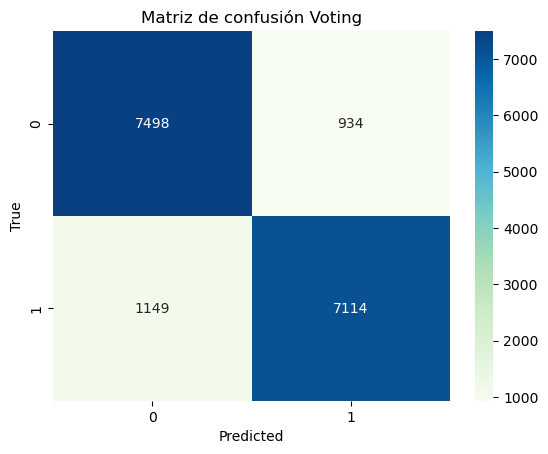

In [245]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, cmap='GnBu', annot=True, fmt='g')
plt.title('Matriz de confusión Voting')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

A continuacion verificamos como se comporta nuestro modelo de voting con el dataset de train.

In [246]:
y_pred_train = voting_model.predict(x_train_minmax)
mostrar_scores(y_train, y_pred_train)

Accuracy: 0.9224489795918367
Recall: 0.9129149377593361
Precision: 0.929155888718788
f1 score: 0.920963817596735


Como podemos ver presenta cierto overtrain, sin embargo es de los mas bajos entre los modelos.

## Evaluación con el dataset de test

In [247]:
df_test = pd.read_csv('https://drive.usercontent.google.com/download?id=1ruDne6JVJTwK0TbDNQEUfUtoxA6gVTiy&export=download&authuser=0&confirm=t&uuid=2892328a-d7d8-47c7-98e1-3e69ef723100&at=APZUnTU5aCf9tHsTaF3PM7aD9Lym:1695760323667')

df_test.shape

(26535, 31)

### Imputacion

In [248]:
nuevas_columnas = {
    'arrival_date_year' : 'year',
    'arrival_date_month' : 'month',
    'arrival_date_week_number' : 'week_number',
    'arrival_date_day_of_month' : 'day_of_month',
    'meal' : 'meal_type',
    'agent' : 'agent_id',
    'adr' : 'average_daily_rate'
}
df_test.rename(columns = nuevas_columnas, inplace = True)

Imputacion children, company y adults

In [249]:
df_test['total_nights'] = df_test['stays_in_week_nights'] + df_test['stays_in_weekend_nights']
df_test['children'].fillna(0, inplace=True)
df_test['total_people'] = df_test['adults'] + df_test['children'] + df_test['babies']
df_test['meal_type'].replace(['SC', 'Undefined'], 'NoMeal', inplace=True)
df_test.drop(columns=['company'], inplace=True)

Imputación de agent id

In [250]:
for index, row in df_test.iterrows():
    if (pd.isna(row['agent_id'])) & (row['distribution_channel'] == 'Direct'):
        df_test.loc[index, 'agent_id'] = -1

for index, row in df_test.iterrows():
    if (not pd.isna(row['agent_id'])) or (row['distribution_channel'] == 'Direct'):
        continue
    if row['hotel'] == 'City Hotel':
        if row['country'] == 'PRT':
            df_test.loc[index, 'agent_id'] = 1.0
        else: 
            df_test.loc[index, 'agent_id'] = 9.0
    else:
        df_test.loc[index, 'agent_id'] = 240.0

Imputación de country

In [251]:
for index, row in df_test.iterrows():
    if pd.isna(row['country']) and row['deposit_type'] == 'Non Refund':
        df_test.loc[index, 'country'] = 'PRT'

for index, row in df_test.iterrows():
    if pd.isna(row['country']) and (row['market_segment'] == 'Corporate' or row['market_segment'] == 'Offline TA/TO' or row['market_segment'] == 'Direct'):
        df_test.loc[index, 'country'] = 'PRT'

In [252]:
mejor_modelo = modelo

Por ultimo, realizamos la misma ingenieria de features que cuando entrenamos cada modelo y mandamos a predecir el conjunto de test con el mejor modelo de cada tipo de ensamble. Este resultado es el que se submitea a kaggle para ver que tan bien generaliza nuestro modelo.

In [253]:
df_encode = df_test.copy()

df_encode['agent_id'] = df_test['agent_id'].apply(lambda x: x if x in list(df_agentes_mayoritarios['agent_id']) else 'Otros')
df_encode['country'] = df_test['country'].apply(lambda x: x if x in list(df_paises_mayoritarios['country']) else 'Otros')

columns.remove('is_canceled')
df_filtrado = df_encode[columns]
columns.append('is_canceled')
df_test_con_dummies = pd.get_dummies(df_filtrado, columns=dummy_columns, drop_first=True).reset_index(drop=True)

df_test_con_dummies['cuarto_correcto'] = df_encode['reserved_room_type'] == df_encode['assigned_room_type']
df_test_con_dummies['cuarto_correcto'] = df_test_con_dummies['cuarto_correcto'].apply(lambda x: 1 if x == True else 0)

df_a_testear = df_test_con_dummies

y_pred = mejor_modelo.predict(df_a_testear)

df_prediccion = pd.DataFrame(y_pred, columns=['is_canceled'])
df_prediccion['id'] = df_test['id']
df_prediccion = df_prediccion[['id', 'is_canceled']]


df_prediccion.to_csv('prediccion.csv', index=False)